<a href="https://colab.research.google.com/github/wfwiggins/RSNA-NLP-2020/blob/master/RSNA20_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSNA 2020: Hands-on AI for Non-Coders**

## **Basics of Information Extraction from Radiology Reports**

In this demonstration, we will utilize techniques of _natural language processing_ (NLP) to train a classifier, which will analyze the text of radiology reports for chest radiographs to predict whether a report is **normal** or **abnormal**.

# System Setup & Downloading the Data

- The first step will install the necessary libraries, then the system will restart. This _WILL_ generate an error message, which can safely be ignored 😉.
- In the second step, we will download the [NLM Open-i "Indiana University Chest X-ray Reports" dataset](https://openi.nlm.nih.gov/faq#collection).

In [ ]:
#@title **Installing libraries & restarting...**

# Installing dependencies
import os
from IPython.display import clear_output

!pip install fastai --upgrade >/dev/null
!pip install xmltodict >/dev/null

clear_output()
os.kill(os.getpid(), 9)

In [1]:
#@title **Downloading the data...**

!curl -s https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz | tar xvz >/dev/null

print('Success!')

Success!


# Reformatting the Data

Each of the reports is stored in _extensible markup language_ (XML) format. In order to work with the report text data more easily, we will extract the data and put it into a `pandas.DataFrame`, which is a tabular data structure.

The XML metadata contains [MeSH terms](https://www.ncbi.nlm.nih.gov/mesh/) for each report. We will use these to create the _label_ for each report in our dataset. These labels will serve as the targets for training our classifier to predict whether the report is **normal** or **abnormal**.

In [ ]:
#@title **Extracting the data...**

import glob
import xmltodict
from fastai.basics import *

def xml_parse(f):
    with open(f) as xml:
        report_dict = xmltodict.parse(xml.read())
    xml.close()
    return report_dict

def get_label(report):
    label = L(report['eCitation']['MeSH']['major'])
    return 'normal' if label[0].lower() == 'normal' else 'abnormal'

def get_text(report):
    text_dict = {}
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]
    text_dict['findings'] = findings['#text'] if '#text' in findings else ''
    impression = text[3]
    text_dict['impression'] = impression['#text'] if '#text' in impression else ''
    return text_dict

def process_report(report):
    label = get_label(report)
    report_dict = get_text(report)
    report_dict['label'] = label
    return report_dict

fps = L(glob.glob('/content/ecgen-radiology/*'))
reports = fps.map(xml_parse)
reports_df = pd.DataFrame(reports.map(process_report))
reports_df

,findings,impression,label
0,Normal heart size and mediastinal contours. Patchy right lower lobe airspace opacities. No pleural effusion or pneumothorax. Visualized osseous structures are unremarkable in appearance.,"Mild, nonconsolidating right lower lobe airspace disease. This may represent an early pneumonia.",abnormal
1,"The heart is normal in size. The mediastinum is stable. Innumerable XXXX bilateral nodules are identified, most of which appear calcified on XXXX examination. There is no acute infiltrate or effusion. XXXX lingular scarring and/or atelectasis.",No acute disease.,abnormal
2,The lungs are clear. There is no pleural effusion or pneumothorax. There has been a XXXX XXXX sternotomy. The heart is not enlarged. Some atherosclerotic changes of the aorta are seen. The skeletal structures are normal.,No acute pulmonary disease.,abnormal
3,"Heart size and mediastinal contours are stable. Atherosclerotic calcifications of the aorta. Moderate severe hyperexpansion of the lungs and decreased peripheral vascular markings, consistent with emphysema. Stable biapical pleural-parenchymal scarring. Scattered granulomas. No abnormal airspace consolidation. No pneumothorax or pleural effusion.",1. Stable emphysematous changes. 2. Stable biapical pleural-parenchymal scarring.,abnormal
4,,,normal
...,...,...,...
3950,"Cardiac And Mediastinal Contours Are Unremarkable. Pulmonary vascularity is within normal limits. No focal air space opacities, pleural effusion, or pneumothorax. XXXX are grossly unremarkable. There are some minimal degenerative changes of the thoracic spine. Evidence of chronic granulomatous disease.",1. Clear lungs.,abnormal
3951,"Frontal and lateral views of the chest show normal size and configuration of the cardiac silhouette. There is aortic XXXX vascular calcification. And there is a hyper left lung calcified granuloma. Normal mediastinal contour, pulmonary XXXX and vasculature, central airways and lung volumes. No pleural effusion. There are vascular and skeletal senescent changes.","No acute or active cardiac, pulmonary or pleural disease.",abnormal
3952,Cardiac and mediastinal contours are within normal limits. The lungs are clear. Multilevel cervical XXXX arthritis.,No acute findings.,abnormal
3953,The heart size is persistently enlarged. Lung volumes are low. Lungs are clear. There is no pleural line to suggest pneumothorax or costophrenic XXXX blunting to suggest large pleural effusion. Bony structures are within normal limits.,No acute cardiopulmonary findings.,abnormal


# Exploring the data

As you'll see in the table above, there are some reports where the "Impression" states something along the lines of "No acute cardiopulmonary abnormality" but the label is "abnormal". This is usually due to a chronic incidental finding or artifact that is mentioned in the "Findings", but isn't included in the "Impression".

> We'll revisit this point later when we're deciding which text from the report we want to use to train our classifier.

For now, let's look through a little more of the data and see how many normals and abnormals we have to work with.

In [ ]:
#@title **Run this cell several times to view random samples of the data**

reports_df.sample(5)

,findings,impression,label
1563,Lungs are clear bilaterally. Cardiac and mediastinal silhouettes are normal. Pulmonary vasculature is normal. No pneumothorax or pleural effusion. No acute bony abnormality.,No acute cardiopulmonary abnormality.,normal
3205,,Heart size is normal in the lungs are clear.,normal
854,Normal heart size. Tortuous calcified aorta. Scattered granulomas. No lobar pneumonia. Probable XXXX post your recess effusions. Kyphotic degenerated osteopenic thoracic spine.,Probable XXXX posterior recess effusions with mild basilar atelectasis. No lobar pneumonia.,abnormal
1731,The lungs are clear. There is no pleural effusion or pneumothorax. There is no evidence for mass lung apices. The heart is normal. There are atherosclerotic changes of the aorta. The skeletal structures are unremarkable.,1. No acute pulmonary disease. No evidence for apical mass.,abnormal
2287,"Apparent cardiomegaly XXXX at XXXX partially accentuated by low lung volumes. No focal consolidation, pneumothorax or large pleural effusion. Right base calcified granuloma. Stable right infrahilar nodular density (lateral view). Negative for acute bone abnormality.",Borderline cardiomegaly without heart failure.,abnormal


Here are some of the things you may have noticed about the data, as you reviewed it:
- Some reports only have an Impression (i.e. no separate Findings section)
- Many reports contain blocks of "XXXX" text. This is due to the fact that these reports were anonymized prior to releasing them as an open data set. These blocks likely represent _named entities_ or dates.
- As expected, there is wide variation in the length of these chest radiograph reports.

<hr>

Next, let's count how many of each label we have.


Abnormal: 2564
Normal: 1391



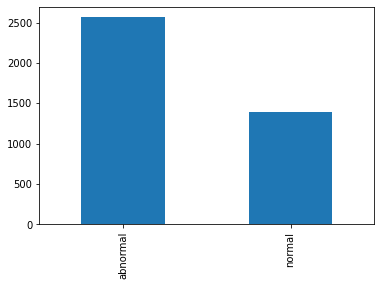

In [ ]:
#@title **Label counts: # of Normals & Abnormals**
label_counts = reports_df.label.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
print()
label_counts.plot.bar();

As we see in the bar graph above, there are almost twice as many abnormal reports as there are normal reports. This will be important to remember as we partition our data into training, validation, and test sets.

In fact, we'll go ahead and split off ("hold out") the test set right now to ensure our model is not exposed to it until the very end. 

We'll set it up such that the our test set is 15% of our full data set and keep the relative percentage of labels the same as in our full dataset.

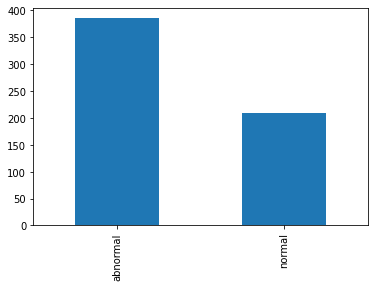

In [ ]:
#@title **Test set label counts**
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(reports_df, test_size=0.15, stratify=reports_df.label.values)
test_counts = test.label.value_counts()
test_counts.plot.bar();

# Language Modeling

The types of algorithms we use in NLP work with with numbers, not text. Therefore, we need a way to convert text into numbers.

## Tokenization

_Tokenization_ is the process by which we split text into chunks or _tokens_. An individual token could be a sentence or phrase, a word, a part of a word, or a single character. Most often, we choose to tokenize at the word or sub-word level.

Each token is assigned a sequential integer value and the collection of token-integer pairs is called our _vocabulary_.

## Embedding

While these integers map one-to-one onto our tokens, their numeric value is otherwise meaningless. To embed more information into the numeric representation of our tokens, we employ a process called _language modeling_. We can either use a pre-trained language model for this _embedding_ or we can fine-tune a language model to better model our "radiology language". This latter process is called _transfer learning_.

In [ ]:
#@title **Word Tokenization**

from fastai.text.all import *

spacy = WordTokenizer()
text = reports_df.loc[0, 'findings']
print('Original text:')
print(text)
print()
tkns = first(spacy([text]))
print('After word tokenization (only showing first 10 tokens):')
print(coll_repr(tkns))

Original text:
Normal heart size and mediastinal contours. Patchy right lower lobe airspace opacities. No pleural effusion or pneumothorax. Visualized osseous structures are unremarkable in appearance.

After word tokenization (only showing first 10 tokens):
(#28) ['Normal','heart','size','and','mediastinal','contours','.','Patchy','right','lower'...]


In [ ]:
#@title **fast.ai Tokenization**

tkn = Tokenizer(spacy)
toks = tkn(text)
print(coll_repr(toks, 15))

(#33) ['xxbos','xxmaj','normal','heart','size','and','mediastinal','contours','.','xxmaj','patchy','right','lower','lobe','airspace'...]


## Added features from fast.ai

You'll notice some odd-appearing tokens in the above output. These are special tokens that indicate certain things about the text.
- `'xxbos'` indicates the beginning of the text _stream_
- `'xxmaj'` indicates that the following character was capitalized before fast.ai lowered it

These special tokens enrich the data while reducing the vocab by eliminating redundant upper and lower case variants of individual words.